In [1]:
# Catherine Beazley
# Spark HW DS6003
# 1-28-2019

In [2]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

In [3]:
# Initializing the spark environment 
conf = pyspark.SparkConf().setAppName('cmb5et').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

In [4]:
# Connecting to S3 bucket and reading csv into Spark dataframe
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'checkouts-by-title-head.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

In [5]:
pddf = pd.read_csv(data_location)

In [6]:
# Removing Nas to get rid of the error from mixing datatypes
pddf = pddf.dropna() 

In [7]:
# Creating the Spark Dataframe
df = sqlc.createDataFrame(pddf)

In [8]:
# Converting to and Reading from Parquet
parquetPath = '/home/ec2-user/SageMaker/Open-Data-Lab/education/Spark19SpDS6003-001/cmb5et_test-parquet2'
df.write.parquet(parquetPath)
df = sqlc.read.parquet(parquetPath)

In [9]:
display(df)

DataFrame[UsageClass: string, CheckoutType: string, MaterialType: string, CheckoutYear: bigint, CheckoutMonth: bigint, Checkouts: bigint, Title: string, Creator: string, Subjects: string, Publisher: string, PublicationYear: string]

In [10]:
# ML Assignment: Predicting Usage Class Using Logistic Regression: Do CheckoutYear, CheckoutMonth, 
# and Checkouts predict UsageClass, meaning whether the item is physical or digital? 

In [11]:
df = df.select('UsageClass', 'CheckoutYear', 'CheckoutMonth', 'Checkouts')

In [12]:
# Vectorizing by creating a dense vector of the features 
from pyspark.ml.feature import RFormula
rf = RFormula(formula="~ CheckoutYear +  CheckoutMonth + Checkouts")
final_df_rf = rf.fit(df).transform(df)
final_df_rf.show()

+----------+------------+-------------+---------+-----------------+
|UsageClass|CheckoutYear|CheckoutMonth|Checkouts|         features|
+----------+------------+-------------+---------+-----------------+
|  Physical|        2005|            4|        3| [2005.0,4.0,3.0]|
|  Physical|        2005|            4|        4| [2005.0,4.0,4.0]|
|  Physical|        2005|            4|        1| [2005.0,4.0,1.0]|
|  Physical|        2005|            4|        3| [2005.0,4.0,3.0]|
|  Physical|        2005|            4|        1| [2005.0,4.0,1.0]|
|  Physical|        2005|            4|        1| [2005.0,4.0,1.0]|
|  Physical|        2005|            4|       16|[2005.0,4.0,16.0]|
|  Physical|        2005|            4|        1| [2005.0,4.0,1.0]|
|  Physical|        2005|            4|        3| [2005.0,4.0,3.0]|
|  Physical|        2005|            4|        5| [2005.0,4.0,5.0]|
|  Physical|        2005|            4|        1| [2005.0,4.0,1.0]|
|  Physical|        2005|            4|        2

In [13]:
# Converting the UsageClass columns to a categorical column with binary 0-1 values
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="UsageClass", outputCol="UsageClassBinary")
indexed = indexer.fit(final_df_rf).transform(final_df_rf)
indexed.show()

+----------+------------+-------------+---------+-----------------+----------------+
|UsageClass|CheckoutYear|CheckoutMonth|Checkouts|         features|UsageClassBinary|
+----------+------------+-------------+---------+-----------------+----------------+
|  Physical|        2005|            4|        3| [2005.0,4.0,3.0]|             0.0|
|  Physical|        2005|            4|        4| [2005.0,4.0,4.0]|             0.0|
|  Physical|        2005|            4|        1| [2005.0,4.0,1.0]|             0.0|
|  Physical|        2005|            4|        3| [2005.0,4.0,3.0]|             0.0|
|  Physical|        2005|            4|        1| [2005.0,4.0,1.0]|             0.0|
|  Physical|        2005|            4|        1| [2005.0,4.0,1.0]|             0.0|
|  Physical|        2005|            4|       16|[2005.0,4.0,16.0]|             0.0|
|  Physical|        2005|            4|        1| [2005.0,4.0,1.0]|             0.0|
|  Physical|        2005|            4|        3| [2005.0,4.0,3.0

In [14]:
df = indexed.select('features', 'UsageClassBinary')
df.show()

+-----------------+----------------+
|         features|UsageClassBinary|
+-----------------+----------------+
| [2005.0,4.0,3.0]|             0.0|
| [2005.0,4.0,4.0]|             0.0|
| [2005.0,4.0,1.0]|             0.0|
| [2005.0,4.0,3.0]|             0.0|
| [2005.0,4.0,1.0]|             0.0|
| [2005.0,4.0,1.0]|             0.0|
|[2005.0,4.0,16.0]|             0.0|
| [2005.0,4.0,1.0]|             0.0|
| [2005.0,4.0,3.0]|             0.0|
| [2005.0,4.0,5.0]|             0.0|
| [2005.0,4.0,1.0]|             0.0|
| [2005.0,4.0,2.0]|             0.0|
| [2005.0,4.0,6.0]|             0.0|
| [2005.0,4.0,2.0]|             0.0|
| [2005.0,4.0,3.0]|             0.0|
| [2005.0,4.0,3.0]|             0.0|
| [2005.0,4.0,3.0]|             0.0|
| [2005.0,4.0,3.0]|             0.0|
| [2005.0,4.0,1.0]|             0.0|
| [2005.0,4.0,1.0]|             0.0|
+-----------------+----------------+
only showing top 20 rows



In [15]:
from pyspark.ml.classification import LogisticRegression

In [16]:
# Splitting the data into train and test sets
seed = 1996
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 202404, test set N = 50984


In [17]:
# Renaming for the ML engine
trainingDF = trainingDF.withColumnRenamed("UsageClassBinary", "label").withColumnRenamed("features", "features")
testDF = testDF.withColumnRenamed("UsageClassBinary", "label").withColumnRenamed("features", "features")

In [18]:
# Fitting a model to the training data
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(trainingDF)

In [19]:
# Transforming test set to get predictions
predictionsAndLabelsDF = lrModel.transform(testDF)
print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(features=DenseVector([2005.0, 9.0, 1.0]), label=1.0, rawPrediction=DenseVector([5.002, -5.002]), probability=DenseVector([0.9933, 0.0067]), prediction=0.0), Row(features=DenseVector([2005.0, 9.0, 1.0]), label=1.0, rawPrediction=DenseVector([5.002, -5.002]), probability=DenseVector([0.9933, 0.0067]), prediction=0.0), Row(features=DenseVector([2005.0, 9.0, 1.0]), label=1.0, rawPrediction=DenseVector([5.002, -5.002]), probability=DenseVector([0.9933, 0.0067]), prediction=0.0), Row(features=DenseVector([2005.0, 9.0, 1.0]), label=1.0, rawPrediction=DenseVector([5.002, -5.002]), probability=DenseVector([0.9933, 0.0067]), prediction=0.0), Row(features=DenseVector([2005.0, 9.0, 1.0]), label=1.0, rawPrediction=DenseVector([5.002, -5.002]), probability=DenseVector([0.9933, 0.0067]), prediction=0.0)]


In [20]:
# Evaluating the Model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation (areaUnderROC|areaUnderPR) (default: areaUnderROC)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)


In [21]:
eval.setMetricName("areaUnderROC").evaluate(predictionsAndLabelsDF)

0.5

In [22]:
import matplotlib.pyplot as plt

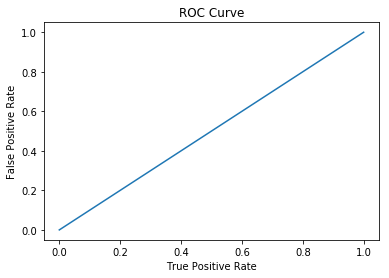

In [23]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [24]:
eval.setMetricName("areaUnderPR").evaluate(predictionsAndLabelsDF)

0.5033638004079711

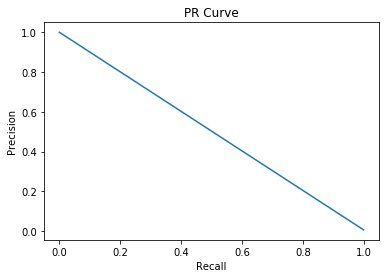

In [25]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve')
plt.show()